In [ ]:
!pip install torch
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [ ]:
import pennylane as qml
import torch
from torch.autograd import Variable
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load and visualize data
standard_data_np = np.load("standard_data.npy")
anomalous_data_np = np.load("anomalous_data.npy")

plt.imshow(np.reshape(standard_data_np[0], (8,8)), cmap="gray")
plt.title("standard sample")
file_plot = "standard_sample.png"
plt.savefig(file_plot)
plt.close()

plt.imshow(np.reshape(anomalous_data_np[4], (8,8)), cmap="gray")
plt.title("anomalous sample")
file_plot = "anomalous_sample.png"
plt.savefig(file_plot)
plt.close()

# Define train set size, the rest will be used for test
train_size = 5000

train_set = torch.tensor(standard_data_np[0:train_size])
standard_data_test = torch.tensor(standard_data_np[train_size:])
anomalous_data_test = torch.tensor(anomalous_data_np)

print("Len train set: ", len(train_set))
print("Let test set: ", len(standard_data_test))

Len train set:  5000
Let test set:  1903


In [ ]:
# Define quantum device
dev = qml.device("default.qubit", wires=6)

def encoder_architecture(params, n_layers = 6, n_qubits = 6, q_compression = 3):
  index = 0
  for i in range(n_layers):
      # Rotation layer
      for j in range(n_qubits):
          qml.RX(params[index], wires=j)
          qml.RY(params[index + 1], wires=j)
          qml.RZ(params[index + 2], wires=j)
          index += 3
      # Entangling layer
      for j in range(n_qubits):
          qml.CNOT(wires=[j, (j + 1) % n_qubits])
  # Final rotations on compressed qubits
  for j in range(q_compression):
      qml.RX(params[index], wires=j)
      qml.RY(params[index + 1], wires=j)
      qml.RZ(params[index + 2], wires=j)
      index += 3

# Quantum encoder pipeline
@qml.qnode(dev, interface='torch')
def encoder(params, state, return_state=False):
    # Prepare initial state
    qml.QubitStateVector(state, wires=range(6))
    # Quantum circuit
    encoder_architecture(params)
    if return_state:
      return qml.state()
    # Return the Z expectation values for the compressed qubits
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(q_compression)]

In [ ]:
# Hyper-parameters of the autoencoder
n_layers = 6
n_qubits = 6
q_compression = 3

# Initialize parameters
n_params = (n_layers * n_qubits + q_compression) * 3
params = Variable(torch.normal( mean=0. , std=0.1, size=(n_params,)), requires_grad=True)

# Visualize quantum circuit
state = train_set[0]

In [ ]:
# Training hyperparameters
epochs = 10
batch_size = 64
steps_per_epoch = int(train_size/batch_size)
optimizer = torch.optim.Adam([params], lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1 , gamma=0.8)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
loss_history = []
params_history = []

# Training
for epoch in range(epochs):
  tot_loss = 0.
  for batch in data_loader:
    optimizer.zero_grad()
    expvals = encoder(params, batch)
    loss = expvals[0].mean() + expvals[1].mean() + expvals[2].mean()
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().numpy()
  loss_history.append(tot_loss/steps_per_epoch)
  params_history.append(params)
  scheduler.step()
  print("Epoch {}: avg_loss = {}".format(epoch+1, tot_loss/steps_per_epoch))

Epoch 1: avg_loss = -1.71781715647209
Epoch 2: avg_loss = -1.977641862069741
Epoch 3: avg_loss = -1.9870676681682375
Epoch 4: avg_loss = -1.9920619305948226
Epoch 5: avg_loss = -1.9974079584146909
Epoch 6: avg_loss = -1.9997251732696624
Epoch 7: avg_loss = -2.0015272129926482
Epoch 8: avg_loss = -2.0026930497088844
Epoch 9: avg_loss = -2.0048528902624154
Epoch 10: avg_loss = -2.0075375550121035


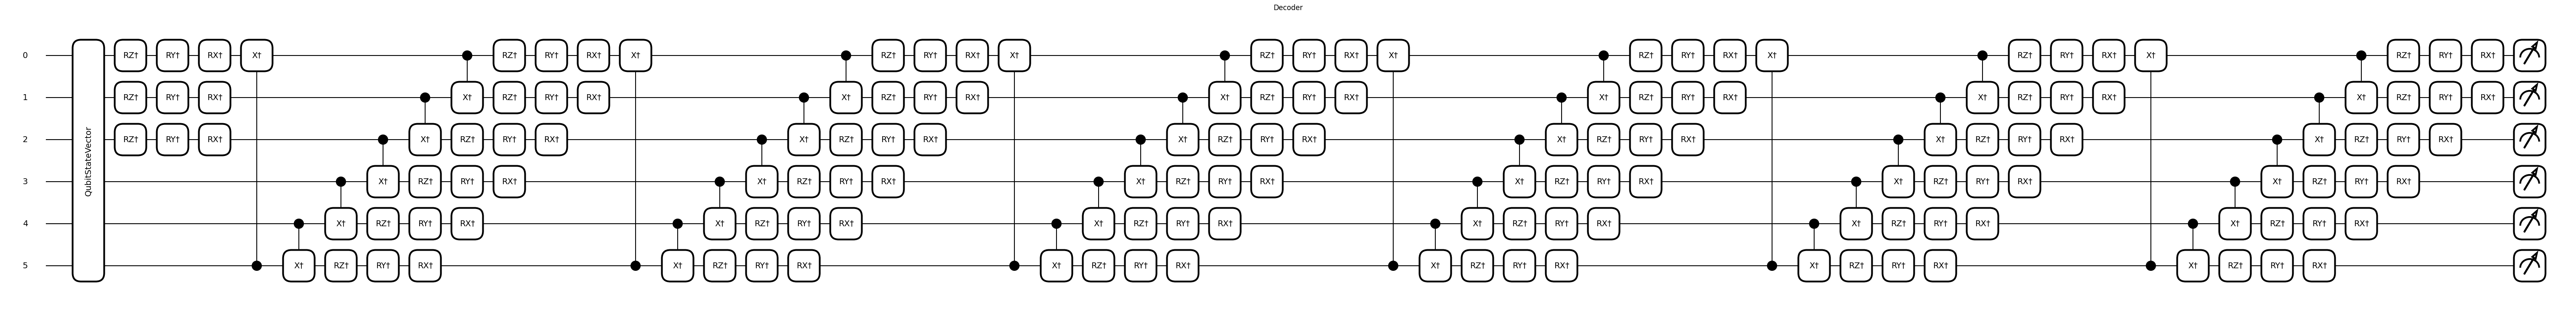

In [ ]:
#Decoder
@qml.qnode(dev, interface='torch')
def decoder(params, state):
    # Prepare initial state
    qml.QubitStateVector(state, wires=range(6))
    # Quantum circuit (encoder inverse)
    qml.adjoint(encoder_architecture)(params)
    return qml.state()

def prepare_decoder_input(latent_space):
  decoder_input = np.zeros((64,), dtype=complex)
  decoder_input[-len(latent_space):] = latent_space
  # Normalize
  norm = np.linalg.norm(decoder_input)
  decoder_input = decoder_input/norm
  return torch.tensor(decoder_input)

# Visualize_decoder
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(decoder)(params, standard_data_test[0])
plt.title("Decoder")
plt.show()
plt.close()

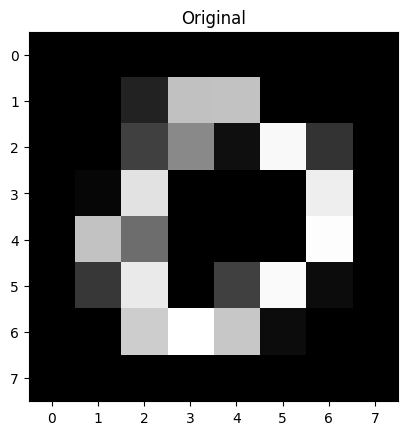

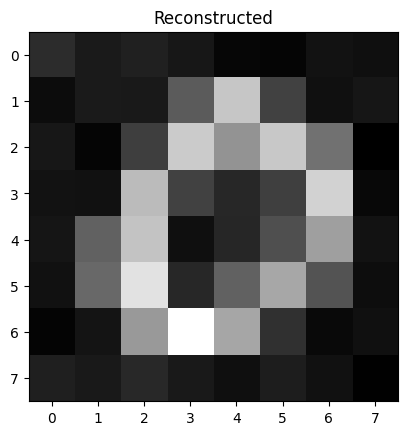

In [ ]:
# Autoencoder simple use
compression = 56 # for 3 out of 6 compressed qubits: compression = 2^5+2^4+2^3
sample = standard_data_test[0]
plt.imshow(np.reshape(sample, (8,8)), cmap="gray")
plt.title("Original")
plt.show()
plt.close()
with torch.no_grad():
  final_state = encoder(params, sample, return_state = True).numpy()
  latent_space = final_state[compression:]
  decoder_input = prepare_decoder_input(latent_space)
  reconstructed = np.absolute(decoder(params, decoder_input).numpy())
plt.imshow(np.reshape(reconstructed, (8,8)), cmap="gray")
plt.title("Reconstructed")
plt.show()
plt.close()



In [ ]:
# Evaluation
test_set_size = len(standard_data_test)
print("Test set size: ", test_set_size)

standard_data_loader = torch.utils.data.DataLoader(standard_data_test, batch_size=256, shuffle=False, drop_last=False)
anomalous_data_loader = torch.utils.data.DataLoader(anomalous_data_test[0:len(standard_data_test)], batch_size=256, shuffle=False, drop_last=False)
loss_s = np.asarray([])
loss_a = np.asarray([])

with torch.no_grad():
    # Standard data
    for batch in standard_data_loader:
      expvals = encoder(params, batch)
      loss = expvals[0].numpy() + expvals[1].numpy() + expvals[2].numpy()
      loss_s = np.concatenate([loss_s,loss])
    # Anomalous data
    for batch in anomalous_data_loader:
      expvals = encoder(params, batch)
      loss = expvals[0].numpy() + expvals[1].numpy() + expvals[2].numpy()
      loss_a = np.concatenate([loss_a,loss])

Test set size:  1903


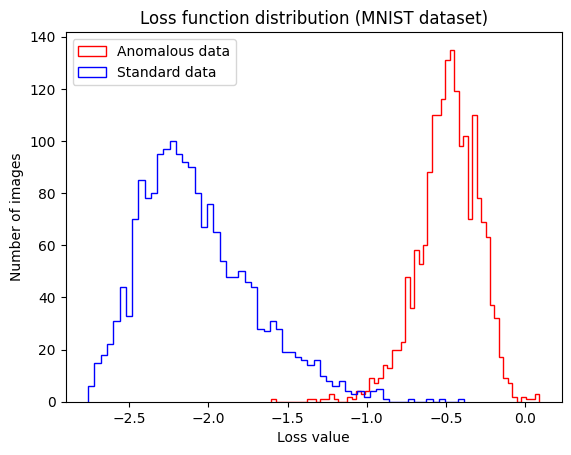

In [ ]:
# Loss function plot
plt.hist(loss_a, bins=60, histtype="step", color="red", label="Anomalous data")
plt.hist(loss_s, bins=60, histtype="step", color="blue", label="Standard data")
plt.ylabel("Number of images")
plt.xlabel("Loss value")
plt.title("Loss function distribution (MNIST dataset)")
plt.legend()
file_plot = "loss_distribution.png"
plt.savefig(file_plot)
plt.show()
plt.close()

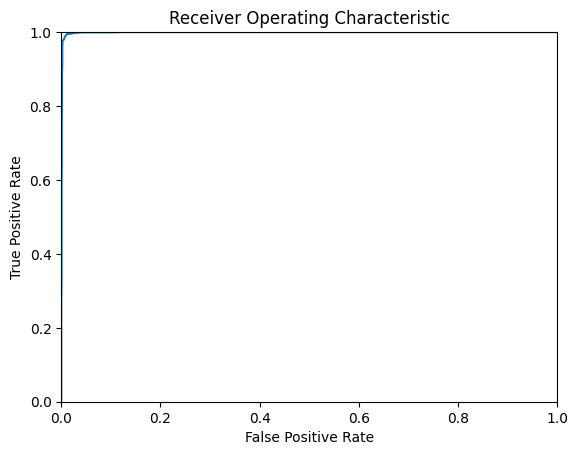

In [ ]:
# Roc
max1 = np.amax(loss_s)
max2 = np.amax(loss_a)
ma = max(max1, max2)
min1 = np.amin(loss_s)
min2 = np.amin(loss_a)
mi = min(min1, min2)

tot_neg = len(loss_s)
tot_pos = len(loss_a)

n_step = 100.0
n_step_int = 100
step = (ma - mi) / n_step
fpr = []
tpr = []
for i in range(n_step_int):
    treshold = i * step + mi
    c = 0
    for j in range(tot_neg):
        if loss_s[j] > treshold:
            c += 1
    false_positive = c / float(tot_neg)
    fpr.append(false_positive)
    c = 0
    for j in range(tot_pos):
        if loss_a[j] > treshold:
            c += 1
    true_positive = c / float(tot_pos)
    tpr.append(true_positive)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
file_plot = "ROC.png"
plt.savefig(file_plot)
plt.show()
plt.close()